### Microalgae Bioreactor with Spray Column 

In [129]:
import numpy as np 
import matplotlib.pyplot as plt 
import pymc
import cronos 
import canon 
from magnus import ParEst

### Spray Development Block

In [130]:
#z transition 
def z_transition(d0):
    return 12 * d0
#z=0.1 #constant z for testing 
def radius_profile(z, d0, r0, theta_initial):
    zt = z_transition(d0)
    r_transition = r0 + zt * np.tan(theta_initial)

    if np.isscalar(z):
        z_val = z
        if z_val < zt:
            return r0 + z_val * np.tan(theta_initial)
        else:
            return r_transition + (z_val - zt) * 0.1
            
    z = np.array(z)
    r = np.zeros_like(z)

    # near-field
    mask_near = z < zt
    r[mask_near] = r0 + z[mask_near] * np.tan(theta_initial)

    # far-field
    mask_far = ~mask_near
    r[mask_far] = r_transition + (z[mask_far] - zt) * 0.1

    return r

### Hydrodynamics Block

In [131]:
import numpy as np

def droplet_hydrodynamics(
    d_drop,          # droplet diameter [m]
    rho_water=1000,  # density of water [kg/m³]
    rho_air=1.2,     # density of air [kg/m³]
    mu_gas=1.8e-5,   # gas viscosity [Pa s]
    Q_gas=0.5e1,      # gas volumetric flowrate [m³/s]  <-- separate from liquid!
    R_col=2.5,      # column radius [m]
    dz=1
):
    g = 9.81
    v_term = (2*g*(rho_water-rho_air)*d_drop**2) / (9*mu_gas)

    A_col = np.pi * R_col**2
    u_gas = Q_gas / A_col      # realistic gas superficial velocity

    v_net = v_term - u_gas
    t_res = dz / v_net

    return v_net, t_res

def droplet_number_concentration(Q_drop, R_col, v_net, d_drop):
    A_col = np.pi * R_col**2
    V_column_per_s = A_col * v_net      # m³/s of reactor

    # droplet volume fraction in that stream
    phi_vol = Q_drop / V_column_per_s   # dimensionless

    # volume of ONE droplet
    V_drop = (4/3)*np.pi*(d_drop/2)**3

    # number of droplets per m³ of reactor
    n0 = phi_vol / V_drop
    return n0

# Example usage
d_drop = 8e-5
Q_drop = 1e-3 # liquid volumetric flowrate
Q_gas  = 5e-4  # gas volumetric flowrate
R_col  = 0.85 #m
dz     = 1

v_net, t_res = droplet_hydrodynamics(d_drop, Q_gas=Q_gas, R_col=R_col, dz=dz)
n0 = droplet_number_concentration(Q_drop, R_col, v_net, d_drop)

print("v_net =", v_net)
print("t_res =", t_res)
print("n0 =", n0, "droplets/m³")


v_net = 0.7739606941195191
t_res = 1.2920552782562558
n0 = 2123365648.6416621 droplets/m³


### Light Distribution Model and Growth Model

In [132]:
IVPDAG = pymc.FFGraph()

#States 
X = pymc.FFVar(IVPDAG, "X") #biomass concentration
A = pymc.FFVar(IVPDAG, "A") #active photosynthesis  
B = pymc.FFVar(IVPDAG, "B") #occupied phoyosynthesis
C = pymc.FFVar(IVPDAG, "C") #damaged photosynthesis 
alpha = pymc.FFVar(IVPDAG, "alpha") #acclimation rate 
Ig = pymc.FFVar(IVPDAG, "G") #acclimation irradiance 
Xd = pymc.FFVar(IVPDAG, "Xd") #dormant biomass concentration
X_s = pymc.FFVar(IVPDAG, "X_s") #biomass concentration in storage tank 
X_ds = pymc.FFVar(IVPDAG, "X_ds") #dead biomass conc. in storage tank

#Controls
v_net = pymc.FFVar(IVPDAG, "v_net") #net velocity 
I0 = pymc.FFVar(IVPDAG, "I0") #incident light intensity
D = pymc.FFVar(IVPDAG, "D") #dilution rate 
#Q_drop = pymc.FFVar(IVPDAG, "Q_gas") #droplet volumetric flowrate 

#initial concentrations 
X0 = pymc.FFVar(IVPDAG, "X0")
A0 = pymc.FFVar(IVPDAG, "A0")
B0 = pymc.FFVar(IVPDAG, "B0")
C0 = pymc.FFVar(IVPDAG, "C0")
alpha0 = pymc.FFVar(IVPDAG, "alpha0")
Ig0 = pymc.FFVar(IVPDAG, "Ig0")  # initial acclimation irradiance
Xd0 = pymc.FFVar(IVPDAG, "Xd0")
X_s0 = pymc.FFVar(IVPDAG, "X_s0")
X_ds0 = pymc.FFVar(IVPDAG, "X_ds0")

#parameters 
#nz = pymc.FFVar(IVPDAG, "nz") #droplet number concentration

#optical parameters
beta_par = pymc.FFVar(IVPDAG, "beta") #extinction coefficient 
sigma_par = pymc.FFVar(IVPDAG, "sigma") #scattering coefficient

#kinetic parameters
kr = pymc.FFVar(IVPDAG, "kr") #repair rate
kd = pymc.FFVar(IVPDAG, "kd") #damage rate
Res = pymc.FFVar(IVPDAG, "R") #Respiration rate 
tau = pymc.FFVar(IVPDAG, "tau") #turnover rate
xi = pymc.FFVar(IVPDAG, "xi") #NPQ rate 
n_h = pymc.FFVar(IVPDAG, "n_h") #HII component 
eta_P = pymc.FFVar(IVPDAG, "eta_P") #photoproduction 
eta_D = pymc.FFVar(IVPDAG, "eta_D") #thermal decay 
eta_qE = pymc.FFVar(IVPDAG, "eta_qE") #qE-quenching 
eta_I = pymc.FFVar(IVPDAG, "eta_I") #qI-quenching
nu = pymc.FFVar(IVPDAG, "nu") #stochiometry 
rho = pymc.FFVar(IVPDAG, "rho") #acclimation rate 
k_chi = pymc.FFVar(IVPDAG, "k_chi") #chi component 
N_0 = pymc.FFVar(IVPDAG, "N_0") #reference RCII
I_qE0 = pymc.FFVar(IVPDAG, "I_qE0") #NPQ interceept 
base0 = pymc.FFVar(IVPDAG, "base0") # base σ
e = pymc.FFVar(IVPDAG, "e") #NPQ slope 
PS2 = pymc.FFVar(IVPDAG, "PS2") #effective cross-section of photosystem II
theta0 = pymc.FFVar(IVPDAG, "theta0") #chi quota 
delta = pymc.FFVar(IVPDAG, "delta") #acclimation rate parameter
lamb = pymc.FFVar(IVPDAG, "lambda") #constant 


#constant
R_col = 0.85 #radius of droplet column

### Mie Theory For Light Model

In [133]:
from scipy.special import spherical_jn, spherical_yn

def complex_refractive_index_droplet(theta_chl, X_gL, wavelength,
                                     a_chl_star,
                                     n_water=1.33,
                                     n_algae=1.39,
                                     rho_cell=1100.0): 
    """
    Computes complex refractive index of a water droplet containing microalgae.
    
    theta_chl : chlorophyll quota [g chl / g DW]
    X_gL      : biomass concentration in droplet [g DW / L]
    wavelength: wavelength [m]
    a_chl_star: chlorophyll-specific absorption [m^2/g chl]
    n_water   : refractive index of water
    n_algae   : refractive index of algal cytoplasm
    rho_cell  : cell density [kg/m^3]
    """

    # ---------- REAL PART (volume fraction mixing) ----------
    # Convert X from g/L → g/m3
    X_g_m3 = X_gL * 1000.0

    # Volume fraction of biomass in droplet
    f_vol = X_g_m3 / rho_cell
    f_vol = max(0.0, min(1.0, f_vol))  # clamp

    n_eff = f_vol * n_algae + (1 - f_vol) * n_water

    # ---------- IMAG PART (absorption from chlorophyll) ----------
    # Chlorophyll concentration in droplet [g/L → g/m3]
    C_chl_m3 = theta_chl * X_gL * 1000.0

    # absorption coefficient a(λ)
    a_lambda = a_chl_star * C_chl_m3   # [1/m]
    k_eff = a_lambda * wavelength / (4 * np.pi)
    n_new = n_eff + 1j * k_eff
    return n_new 

def mie_ab(m_rel, x, nmax):
    a = np.zeros(nmax, dtype=complex)
    b = np.zeros(nmax, dtype=complex)

    y = m_rel * x
    for n in range(1, nmax+1):
        jx   = spherical_jn(n, x)
        jx_p = spherical_jn(n, x, derivative=True)
        yx   = spherical_yn(n, x)
        yx_p = spherical_yn(n, x, derivative=True)
        hx   = jx + 1j*yx
        hx_p = jx_p + 1j*yx_p

        jy   = spherical_jn(n, y)
        jy_p = spherical_jn(n, y, derivative=True)

        a[n-1] = (m_rel*jy*jx_p - jx*jy_p) / (m_rel*jy*hx_p - hx*jy_p)
        b[n-1] = (jy*jx_p - m_rel*jx*jy_p) / (jy*hx_p - m_rel*hx*jy_p)

    return a, b

def mie_Qext(m_rel, r, wavelength):
    x = 2*np.pi*r / wavelength
    nmax = int(np.round(x + 4*x**(1/3) + 2))
    a, b = mie_ab(m_rel, x, nmax)
    n = np.arange(1, nmax+1)
    Q_ext = (2/x**2) * np.sum((2*n+1)*np.real(a + b))
    Q_sca = (2/x**2) * np.sum((2*n+1)*(np.abs(a)**2 + np.abs(b)**2))
    return Q_ext, Q_sca

def mie_coeff(d, wavelength, m_rel, n0):
    r = d/2
    Q_ext, Q_sca = mie_Qext(m_rel, r, wavelength)
    C_ext = Q_ext * np.pi * r**2
    C_sca = Q_sca * np.pi * r**2
    beta_mie = n0 * C_ext
    sigma_mie = n0 * C_sca
    return beta_mie, sigma_mie

#Guess initial parameter values
if __name__ == "__main__":
    d_drop = 2e-4
    n0 = 2513070.6710706623
    wavelength = 550e-9
    theta_chi = 3.60
    X_gL = 3.0 
    a_chl_star = 20
    n_new = complex_refractive_index_droplet(theta_chi, X_gL, wavelength, a_chl_star)
    m_rel = n_new / 1.33
    beta_mie, sigma_mie = mie_coeff(d_drop, wavelength, m_rel, n0)
    print("Complex refractive index:", n_new)
    print("m_rel", m_rel)
    print("Extinction coefficient beta:", beta_mie)
    print("Scattering coefficient sigma:", sigma_mie)


Complex refractive index: (1.39+0.009453803619658583j)
m_rel (1.045112781954887+0.0071081230222996864j)
Extinction coefficient beta: 0.15929491726773187
Scattering coefficient sigma: 0.08050660698988449


In [134]:
IVP = cronos.ODESLV()
IVP.set_dag(IVPDAG)

IVP.set_parameter([
    beta_par, sigma_par, base0, kr, kd, Res, tau, xi, n_h, nu,
    eta_P, eta_D, eta_qE, eta_I, k_chi, e, PS2, rho,
    N_0, I_qE0, theta0, delta, lamb
])

IVP.set_constant([I0, D, X0, A0, B0, C0, alpha0, Ig0, Xd0, X_s0, X_ds0])
IVP.set_state([X, A, B, C, alpha, Ig, Xd, X_s, X_ds])

time_grid = np.linspace(0, 86400, 52).tolist()
IVP.set_time(time_grid)
print(time_grid)

# ---------- Light model + radial-averaged μ ----------
b = 0.15
f = 1.0 - b
sqrt3 = 3.0**0.5
K = 200                  # number of radial steps
#dr = R_col / K           # radial step size
r = np.linspace(0, R_col, 200)
dr = r[1] - r[0]

# optics from biomass in tank 2
X_tot     = X_s + X_ds
beta_par  = beta_mie  * X_tot
sigma_par = sigma_mie * X_tot

# growth-related quantities that do NOT depend on radius
theta = theta0 * Ig**k_chi
N     = N_0   * Ig**lamb
I_qE  = I_qE0 + e * Ig

denom_mu = 1.0 + eta_D + eta_qE*alpha + A*eta_P + C*eta_I

# two-flux boundary conditions at r = 0 (or wall: adjust as needed)
F_plus  = I0     
F_minus = 0.0

# integral for ∫ μ(r) r dr
integral_mu_r = 0.0

for k in range(K + 1):
    r_k = k * dr

    # 1) compute local intensity at this radius
    dF_plus  = sqrt3 * (-beta_par*F_plus + sigma_par*(f*F_plus + b*F_minus))
    dF_minus = sqrt3 * ( beta_par*F_minus - sigma_par*(f*F_minus + b*F_plus))
    F_plus   = F_plus  + dF_plus  * dr
    F_minus  = F_minus + dF_minus * dr
    I = (F_plus + F_minus) * 4.57     

    # 2) compute local μ(r_k)
    # ---------- PSII / NPQ ODEs ----------
    denom = 1.0 + eta_D + eta_qE*alpha + A*eta_P + C*eta_I
    mu_k  = (I * base0 * nu * (A * eta_P) / denom - Res) * theta   # σ = base0 or σ_PS2 as you choose

    sigma_PS2 = base0 * eta_P / (N * (1.0 + eta_D + eta_qE*alpha + eta_P))

    k_AB = I * sigma_PS2 * A
    k_BA = B / tau
    k_BC = kd * sigma_PS2 * I * B
    k_CB = kr * C

    dA = -k_AB + k_BA
    dB =  k_AB - k_BA + k_CB - k_BC
    dC =  k_BC - k_CB

    NPQ_target = (I**n_h) / (I_qE**n_h + I**n_h)
    dalpha = -xi * (alpha - NPQ_target)
    mu_k = (I * base0 * nu * (A * eta_P) / denom_mu - Res) * theta

    # 3) accumulate weighted integral ∫ μ(r) r dr with trapezoid weights
    if k == 0 or k == K:
        integral_mu_r += mu_k * r_k
    else:
        integral_mu_r += 2.0 * mu_k * r_k


    # radial average: μ̄ = 2 / R^2 ∫ μ(r) r dr
    integral_mu_r = 0.5 * dr * integral_mu_r
    mu_avg = 2.0 * integral_mu_r / (R_col**2)

mu_max = 5.0e-5      # or whatever is physically reasonable
eps_mu = 1e-12
mu_avg_1 = mu_avg / (1.0 + ((mu_avg*mu_avg + eps_mu)**0.5) / mu_max)



dIg = delta * (I - Ig) * mu_avg_1

# ---------- Biomass ODEs ----------
dX  = mu_avg_1 * X + D * X_s - D * X
dXd = Res * X     - D * Xd

# growth in dark tank
I_dark = 0.0
mu_dark = (I_dark * base0 * nu *
           (A * eta_P) /
           (1.0 + eta_D + eta_qE*alpha + A*eta_P + C*eta_I)
           - Res) * theta

dX_s  = mu_dark * X_s + D * X   - D * X_s
dX_ds = Res * X_s      - D * X_ds

IVP.set_differential([dX, dA, dB, dC, dalpha, dIg, dXd, dX_s, dX_ds])
IVP.set_initial([X0, A0, B0, C0, alpha0, Ig0, Xd0, X_s0, X_ds0])

Y = [I, X, A, B, C, alpha, Ig, mu_avg_1, X_s, mu_dark]
nY = len(Y)
F = [{j: Y[j] for j in range(nY)} for _ in time_grid]

IVP.set_function(F)
IVP.setup()
print(IVP.eqn_function)


[0.0, 1694.1176470588234, 3388.235294117647, 5082.35294117647, 6776.470588235294, 8470.588235294117, 10164.70588235294, 11858.823529411764, 13552.941176470587, 15247.05882352941, 16941.176470588234, 18635.294117647056, 20329.41176470588, 22023.529411764706, 23717.647058823528, 25411.76470588235, 27105.882352941175, 28800.0, 30494.11764705882, 32188.235294117643, 33882.35294117647, 35576.470588235294, 37270.58823529411, 38964.70588235294, 40658.82352941176, 42352.94117647059, 44047.05882352941, 45741.17647058823, 47435.294117647056, 49129.41176470588, 50823.5294117647, 52517.647058823524, 54211.76470588235, 55905.882352941175, 57600.0, 59294.11764705882, 60988.23529411764, 62682.35294117647, 64376.47058823529, 66070.58823529411, 67764.70588235294, 69458.82352941176, 71152.94117647059, 72847.05882352941, 74541.17647058822, 76235.29411764705, 77929.41176470587, 79623.5294117647, 81317.64705882352, 83011.76470588235, 84705.88235294117, 86400.0]
[{0: Z10045, 1: X, 2: A, 3: B, 4: C, 5: alpha

In [135]:
IVP.options.DISPLEVEL = 1     # display numerical integration results
IVP.options.RESRECORD = 100    # record 50 points along time horizon

# Solver tolerances - adjust for stiff systems
IVP.options.RTOL = 1e-4       # relative tolerance (default 1e-6)
IVP.options.ATOL = 1e-6       # absolute tolerance (default 1e-8)
IVP.options.HMAX  = 1e2      # allow large steps
IVP.options.HMIN  = 1e-12    # allow shrinking until nearly zero

param_vals = [
    # --- optical (3) ---
    beta_mie,      # 1  beta_par
    sigma_mie,     # 2  sigma_par
    1.75,          # 3  base0

    # --- kinetic rates (7) ---
    5.50e-5,       # 4  kr
    6.41e-7,       # 5  kd
    1.78e-5,       # 6  Res
    5e-3,       # 7  tau
    5.95e-2,       # 8  xi
    2.26,          # 9  n_h
    4.0,           # 10 nu

    # --- photochemistry / quenching (6) ---
    1.14e1,        # 11 eta_P
    5.0e0,         # 12 eta_D
    1.98e1,        # 13 eta_qE
    7.87e1,        # 14 eta_I
    -1.89e-1,      # 15 k_chi
    4.48e-1,       # 16 e

# --- acclimation / photoacclimation (6) ---
    1.38e-1,       # 17 rho
    1.71,          # 18 N_0
    8.13e2,        # 19 I_qE0
    3.60,          # 20 theta0
    1.38e-1,       # 21 delta
    1.22e-1       # 22 lamb

]

const_vals = [
    50,    # I0
    0.001,   # D
    0.1,   # X0
    0.5,   # A0
    0.3,   # B0
    0.2,   # C0
    0.0,   # alpha0
    180,    # Ig0 (initial acclimation irradiance)
    0.0,   # Xd0
    0.0,   # X_s0
    0.0    # X_ds0
]

# Run the IVP
IVP.solve_state(param_vals,const_vals)

 @t = 0.000000e+00 :
  x[0] = 1.000000e-01
  x[1] = 5.000000e-01
  x[2] = 3.000000e-01
  x[3] = 2.000000e-01
  x[4] = 0.000000e+00
  x[5] = 1.800000e+02
  x[6] = 0.000000e+00
  x[7] = 0.000000e+00
  x[8] = 0.000000e+00
 @t = 1.694118e+03 :
  x[0] = 5.519052e-02
  x[1] = 8.177953e-01
  x[2] = 5.010681e-08
  x[3] = 1.822065e-01
  x[4] = 9.030680e-01
  x[5] = 1.804851e+02
  x[6] = 8.972246e-04
  x[7] = 5.037432e-02
  x[8] = 6.104628e-04
 @t = 3.388235e+03 :
  x[0] = 5.583574e-02
  x[1] = 8.340057e-01
  x[2] = 4.564895e-08
  x[3] = 1.659961e-01
  x[4] = 9.024394e-01
  x[5] = 1.809592e+02
  x[6] = 9.675754e-04
  x[7] = 5.431241e-02
  x[8] = 8.854191e-04
 @t = 5.082353e+03 :
  x[0] = 5.817573e-02
  x[1] = 8.487740e-01
  x[2] = 4.158768e-08
  x[3] = 1.512279e-01
  x[4] = 9.018696e-01
  x[5] = 1.814275e+02
  x[6] = 1.010334e-03
  x[7] = 5.671001e-02
  x[8] = 9.739950e-04
 @t = 6.776471e+03 :
  x[0] = 6.067505e-02
  x[1] = 8.622283e-01
  x[2] = 3.788774e-08
  x[3] = 1.377736e-01
  x[4] = 9.0130

<Status.Normal: 0>

In [136]:
#simulated results
Pred_Exp = []
for rec in IVP.results_state: 
    Pred_Exp.append([rec.t] + list(rec.x)) 
Pred_Exp = np.array(Pred_Exp) 


Text(0.5, 1.0, 'Light Profile')

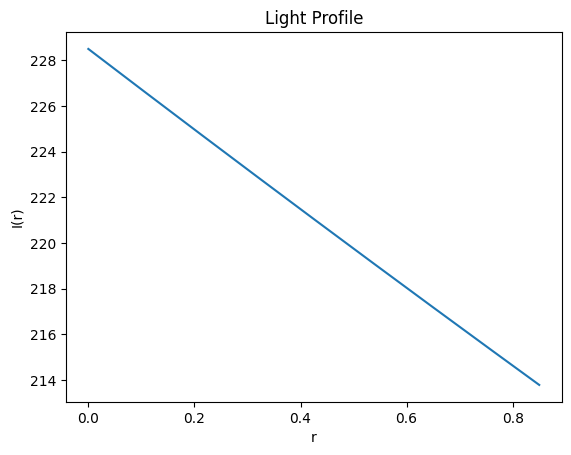

In [137]:
# at final time:
X_s_val  = Pred_Exp[-1, 8]
X_ds_val = Pred_Exp[-1, 9]


def light_profile_twoflux_numeric(X_s_val, X_ds_val,
                                  I0_val, beta_mie_val, sigma_mie_val,
                                  R_col, K=200):
    b = 0.15
    f = 1.0 - b
    sqrt3 = np.sqrt(3.0)

    X_tot = X_s_val + X_ds_val
    beta_par  = beta_mie_val  * X_tot
    sigma_par = sigma_mie_val * X_tot

    r = np.linspace(0.0, R_col, K)
    dr = r[1] - r[0]

    F_plus  = I0_val
    F_minus = 0.0
    I_profile = np.zeros_like(r)

    for k in range(K):
        I_profile[k] = (F_plus + F_minus) * 4.57
        if k < K - 1:
            dF_plus  = sqrt3 * (-beta_par*F_plus + sigma_par*(f*F_plus + b*F_minus))
            dF_minus = sqrt3 * ( beta_par*F_minus - sigma_par*(f*F_minus + b*F_plus))
            F_plus  += dF_plus  * dr
            F_minus += dF_minus * dr

    return r, I_profile

r, I_r = light_profile_twoflux_numeric(
    X_s_val, X_ds_val,
    I0_val = 50,       
    beta_mie_val = 0.15929491726773187,
    sigma_mie_val = 0.08050660698988449,
    R_col = R_col
)

plt.plot(r, I_r)
plt.xlabel('r')
plt.ylabel('I(r)')
plt.title('Light Profile')


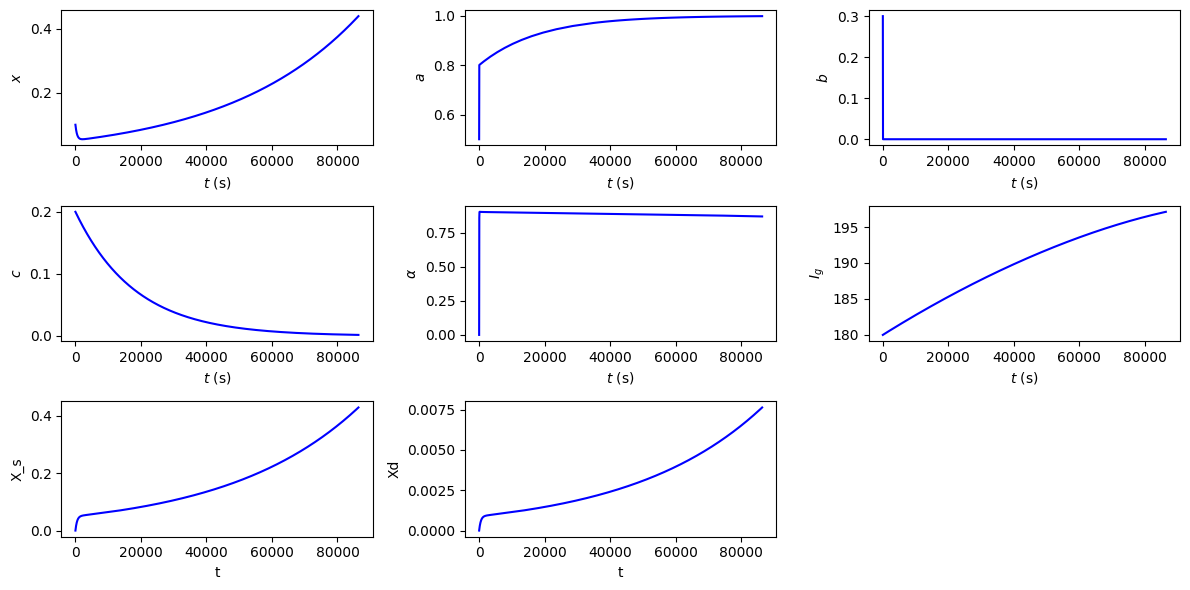

In [138]:
fig, axes = plt.subplots(3, 3, figsize=(12, 6))

# --- x ---
axes[0,0].plot(Pred_Exp[:,0], Pred_Exp[:,1], color="blue")
axes[0,0].set(xlabel="$t$ (s)")
axes[0,0].set(ylabel="$x$")

# --- a ---
axes[0,1].plot(Pred_Exp[:,0], Pred_Exp[:,2], color="blue")
axes[0,1].set(xlabel="$t$ (s)")
axes[0,1].set(ylabel="$a$")

# --- b ---
axes[0,2].plot(Pred_Exp[:,0], Pred_Exp[:,3], color="blue")
axes[0,2].set(xlabel="$t$ (s)")
axes[0,2].set(ylabel="$b$")

# --- c ---
axes[1,0].plot(Pred_Exp[:,0], Pred_Exp[:,4], color="blue")
axes[1,0].set(xlabel="$t$ (s)")
axes[1,0].set(ylabel="$c$")

# --- alpha ---
axes[1,1].plot(Pred_Exp[:,0], Pred_Exp[:,5], color="blue")
axes[1,1].set(xlabel="$t$ (s)")
axes[1,1].set(ylabel=r"$\alpha$")

# --- Ig ---
axes[1,2].plot(Pred_Exp[:,0], Pred_Exp[:,6], color="blue")
axes[1,2].set(xlabel="$t$ (s)")
axes[1,2].set(ylabel="$I_g$")

axes[2,0].plot(Pred_Exp[:,0], Pred_Exp[:,8], color='blue')
axes[2,0].set(xlabel="t")
axes[2,0].set(ylabel="X_s")

axes[2,1].plot(Pred_Exp[:,0], Pred_Exp[:,7], color='blue')
axes[2,1].set(xlabel="t")
axes[2,1].set(ylabel="Xd")
# Remove empty axes 
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
fig.tight_layout()
plt.show()
